# 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive
%cd ANDL_HOMEWORK1_LINK

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive
/gdrive/.shortcut-targets-by-id/14RasmCIKqhEPRMZcyNhd3qdplUPJ-lAw/Homework 1


# ⚙️ Import Libraries

In [2]:
%pip install keras_cv

In [3]:
# Set seed for reproducibility
seed = 42
# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set GPU
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.utils import to_categorical

# Import Keras_cv for augmentations
import keras_cv

2.17.1


# DATA MANAGEMENT

### LOADING

In [4]:
# Load the NPZ file
data = np.load('dataset/cleaned_dataset.npz', allow_pickle=True)

# Print the keys in the file to see what arrays are stored
print("Keys in the npz file:", data.files)

#Store Data in Arrays
images_data = data['images']
labels_data = data['labels']

#Data shapes
INPUT_SHAPE = images_data.shape[1:]

print("Number of Images :", len(images_data))
print("Labels :", len(labels_data))

print("Shape of Images Array :", images_data.shape)
print("Shape of Labels Array :", labels_data.shape)


Keys in the npz file: ['images', 'labels']
Number of Images : 11959
Labels : 11959
Shape of Images Array : (11959, 96, 96, 3)
Shape of Labels Array : (11959, 1)


### SPLIT SETS

In [5]:
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(images_data, labels_data, test_size=0.2, random_state=42, stratify=labels_data)

# Second split: Split the training set into 80% training and 20% validation (this means 64% train, 16% val overall)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Dataset Shapes
IMAGE_SIZE = INPUT_SHAPE[:2]
NUM_CLASSES = 8

# Convert TRAIN and VALIDATION labels to categorical
y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)




### PREPROCESSING

In [6]:
# PREPROCESSING PARAMETERS
BATCH_SIZE = 1024
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Define the augmenter with the desired transformations
augmenter = keras_cv.layers.Augmenter(
    layers=[
        keras_cv.layers.RandomRotation(factor=0.2),
        keras_cv.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        keras_cv.layers.RandomShear(x_factor=0.1, y_factor=0.1),
        keras_cv.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
        keras_cv.layers.RandomBrightness(factor=0.1,value_range=(0, 255)),
        keras_cv.layers.AutoContrast(value_range=(0, 255)),
        keras_cv.layers.RandomSaturation(factor=(0.1, 1)) , # Adjust saturation between 10% and 150%
    ]
)

In [7]:

# Convert Images and Labels of TRAIN into float32 tf array for keras_cv preprocessing
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)


# Preprocess TRAIN
mixorcut = keras_cv.layers.RandomChoice(
	[
		keras_cv.layers.CutMix(),
		keras_cv.layers.MixUp()
	],
	batchwise=True
)
moc_data = mixorcut(
	{
        "images": X_train,
        "labels" : y_train,
	}
)

# Convert back preprocessed TRAIN into numpy array
X_train_np = moc_data["images"].numpy()
y_train_np = moc_data["labels"].numpy()

# Convert VALIDATION as float32 as already done for TRAIN
X_val = X_val.astype('float32')

# Shuffle and batch TRAIN
train_ds_rand = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(AUTOTUNE)


# Apply gaussian noise to TRAIN
gaussian_noise = tfk.layers.GaussianNoise(0.3)
train_ds_rand = train_ds_rand.map(lambda x, y: (gaussian_noise(x, training=True), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)




# function that takes an image and his label
# and returns an array with augmented version of the image with the same label
def augment_data(image, label,num_augmentations=1):
	augmented_images = [augmenter(tf.expand_dims(image, axis=0)) for _ in range(num_augmentations)]
	augmented_images = [tf.squeeze(img, axis=0) for img in augmented_images]
	images_with_original = [image] + augmented_images  # Include the original image
	labels_with_original = [label] * len(images_with_original)  # Repeat the label for both original and augmented images
	return tf.data.Dataset.from_tensor_slices((images_with_original, labels_with_original))


# Apply the augmentation function to each image in the dataset
augmented_dataset = train_ds_rand.unbatch().flat_map(
	lambda image, label: augment_data(image, label),)

# Shuffle vector and build batches
augmented_dataset = augmented_dataset.shuffle(BATCH_SIZE * 100).batch(
	BATCH_SIZE)

# Define training dataset
train_ds_rand = augmented_dataset


In [8]:
# CLEANUP
del mixorcut, gaussian_noise
del X_train, y_train, moc_data, X_train_np, y_train_np, augmented_dataset

In [ ]:
n_augmented_images = len(X_train_np) * 2

augmented_images = np.empty((n_augmented_images, 96, 96, 3), dtype=np.uint8)
augmented_labels = np.empty((n_augmented_images,8), dtype=np.float32)

i = 0
prog = 0.0
for image, label in train_ds_rand:
	if(i/n_augmented_images >= prog + 0.1):
		prog += 0.1
		print(f"{int(prog*100)}%", end=" ")
	augmented_images[i] = image
	augmented_labels[i] = label
	i = i + 1


  train_ds_rand = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

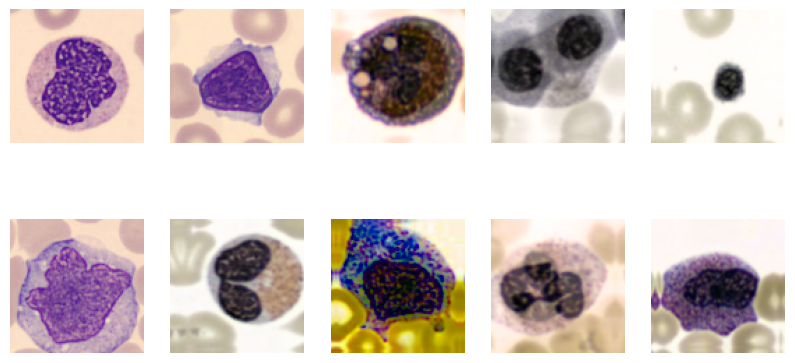

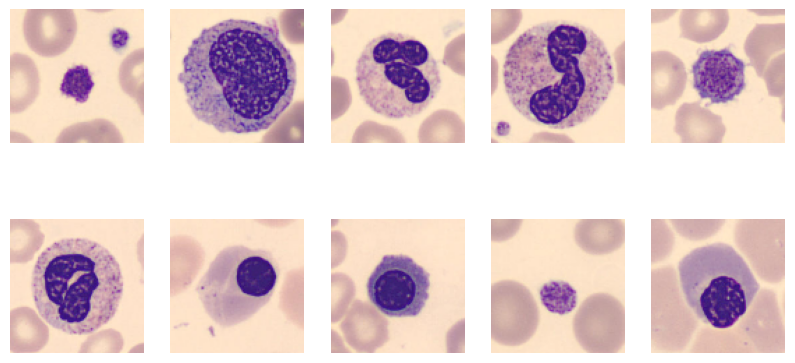

In [9]:
# PLOT THE RESULT OF AUGMENTATION
sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(10, 5))
for i, image in enumerate(sample_images[:10]):
	ax = plt.subplot(2,5, i + 1)
	plt.imshow(image.numpy().astype('uint8'))
	plt.axis("off")

plt.show()

# PLOT OG IMAGES
plt.figure(figsize=(10, 5))
for i, image in enumerate(images_data[:10]):
	ax = plt.subplot(2, 5, i + 1)
	plt.imshow(image)
	plt.axis("off")

plt.show()

# MODEL

### CALLBACK FUNCTIONS

In [10]:
# Custom callback class for real-time plotting
from IPython.display import clear_output
#clear output callback jupyter
from tensorflow.keras.callbacks import Callback

class RealTimePlot(Callback):
    def on_train_begin(self, logs={}):
        # Initializes a dictionary to store training metrics
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        # Set up subplots
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        # Convert axs to a numpy array for indexing
        if not isinstance(axs, np.ndarray):
            axs = np.array([axs])

        # Plot learning curves
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

class ClearOutput(Callback):
	def on_epoch_end(self, epoch, logs=None):
		pass


clear = ClearOutput()
plot = RealTimePlot()

### PARAMETERS

In [11]:
epochs = 200
fine_tune_epochs = 100

### BUILD

In [12]:
from tensorflow.python.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


# Load the EfficientNetV2B0 model with pretrained ImageNet weights, excluding the top layers
base_model = EfficientNetV2B3(include_top=False, weights='imagenet', input_shape=(96, 96, 3))

# Freeze the base model to retain the pre-trained weights
base_model.trainable = False

# Build the classification model
model = models.Sequential([
	tfkl.Input(shape=INPUT_SHAPE),
	base_model,
	tfkl.GlobalAveragePooling2D(),
    tfkl.Dropout(0.3),  # Add dropout to avoid overfitting# Pooling layer
	tfkl.Dense(256, activation='relu'),  # Dense layer with ReLU
	tfkl.BatchNormalization(),
    tfkl.Dropout(0.3),
    tfkl.Dense(128, activation='relu'),  # Dense layer with ReLU
	tfkl.BatchNormalization(),
    tfkl.Dropout(0.3),
	tfkl.Dense(NUM_CLASSES, activation='softmax')  # Final output layer
])

# Compile the model
model.compile(optimizer=tfk.optimizers.AdamW(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

labels = []

# Loop through the dataset to gather all the labels
for x, y in train_ds_rand:
    ax = np.argmax(y,axis=1)
    labels.extend(ax)  # Assuming 'y' is the label for each sample

# Convert labels to numpy array
labels = np.array(labels)

# Calculate class weights using sklearn's compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

# Create a dictionary with class weights
class_weight_dict = {label: weight for label, weight in zip(np.unique(labels), class_weights)}

class_weights = class_weight_dict
# Print the class weights to check
print("Class Weights:", class_weights)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b3 (Functional)       │ (None, 3, 3, 1536)          │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,359,558 (50.96 MB)

 Trainable params: 428,168 (1.63 MB)

 Non-trainable params: 12,931,390 (49.33 MB)

Class Weights: {0: 1.669502617801047, 1: 0.7107169390787519, 2: 1.4047356828193833, 3: 0.7241672975018925, 4: 1.7236486486486486, 5: 1.5257177033492824, 6: 0.6485593220338983, 7: 0.8898837209302326}


### 🛠️ TRAIN

In [ ]:
#unfreeze the last 5
for layer in base_model.layers[-5:]:
	layer.trainable = True
# Train the model
history = model.fit(train_ds_rand, class_weight=class_weights,
                    epochs=epochs,  # Adjust epochs as needed
                    validation_data=(X_val, y_val),
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, mode='auto',
                                                 min_lr=1e-6),
                               EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto',restore_best_weights = True)
	                    ]
                    )

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.3292 - loss: 2.1639 - val_accuracy: 0.7795 - val_loss: 1.1458 - learning_rate: 0.0010
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 131ms/step - accuracy: 0.6170 - loss: 1.2783 - val_accuracy: 0.8558 - val_loss: 0.7119 - learning_rate: 0.0010
Epoch 3/200


In [ ]:
model.save("temporaryEfficentNetV2B3_01.keras")

### FINE TUNE

In [ ]:
layers = base_model.layers
for layer in layers[-20:]:
	layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=tfk.optimizers.AdamW(learning_rate=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy']

              )

# Fine-tune the model
history_fine = model.fit(train_ds_rand,class_weight=class_weights,
                         epochs=fine_tune_epochs,
                         validation_data=(X_val, y_val),
                         callbacks=[
	                         ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, mode='auto',
	                                           min_lr=1e-10),
	                         EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto',restore_best_weights = True),
	                         ])


#fine tune the model more

### TEST

In [ ]:
X_test = X_test.astype('float32')
y_test = to_categorical(y_test, NUM_CLASSES)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# ⏬ Save the Model

In [ ]:
model.save('EfficentNetV2B3_01.keras')
model.summary()